In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [3]:
# Loading the data
df=pd.read_csv(r"Retail_Dataset.csv")

In [4]:
def get_df_info(df):
    """Provides a comprehensive overview of a DataFrame."""
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    print("\n\033[1mUnique values per column:\033[0m")
    print(df.nunique())
    print("\n\033[1mNull values:\033[0m\n", df.isnull().sum())
    print("\n\033[1mDuplicate rows:\033[0m ", df.duplicated().sum())
    print("\n\033[1mDescriptive statistics:\033[0m\n", df.describe().transpose())


In [5]:
# Get the data report
get_df_info(df)


Shape of DataFrame:  (1000000, 13)

Columns in DataFrame:  ['Transaction_ID', 'Date', 'Customer_Name', 'Product', 'Total_Items', 'Total_Cost', 'Payment_Method', 'City', 'Store_Type', 'Discount_Applied', 'Customer_Category', 'Season', 'Promotion']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Transaction_ID     1000000 non-null  int64  
 1   Date               1000000 non-null  object 
 2   Customer_Name      1000000 non-null  object 
 3   Product            1000000 non-null  object 
 4   Total_Items        1000000 non-null  int64  
 5   Total_Cost         1000000 non-null  float64
 6   Payment_Method     1000000 non-null  object 
 7   City               1000000 non-null  object 
 8   Store_Type         1000000 non-null  object 
 9   Discount_Applied   1000000 non-null  bool   
 10  Custo

In [6]:
# Summary for categorical variables
df.describe(include='object').T

,count,unique,top,freq
Date,1000000,811016,31-08-2020 16:57,7
Customer_Name,1000000,329738,Michael Smith,454
Product,1000000,571947,['Toothpaste'],4893
Payment_Method,1000000,4,Cash,250230
City,1000000,10,Boston,100566
Store_Type,1000000,6,Supermarket,166936
Customer_Category,1000000,8,Senior Citizen,125485
Season,1000000,4,Spring,250368
Promotion,666057,2,Discount on Selected Items,333370


In [7]:
# Calculating the percentage of missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

print(missing_percentage)

Promotion    33.3943
dtype: float64


In [8]:
# col Date must convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(f"Col Date New Type: {df['Date'].dtype}")

# Conversion Col Payment Method to category for efficiency memories
df['Payment_Method'] = df['Payment_Method'].astype('category')
print(f"Col Payment_Method New Type: {df['Payment_Method'].dtype}")
print(df['Payment_Method'].cat.categories)

# Print representation as numeric from every value in columnt
print(df['Payment_Method'].cat.codes)

# Convertion Col City to category
df['City'] = df['City'].astype('category')

# Convertion Col Store_Type to category
df['Store_Type'] = df['Store_Type'].astype('category')

# Convertion Col Customer_Category to category
df['Customer_Category'] = df['Customer_Category'].astype('category')

# Convertion Col Season to category
df['Season'] = df['Season'].astype('category')

# Convertion Col Promotion to category
df['Promotion'] = df['Promotion'].astype('category')


Col Date New Type: datetime64[ns]
Col Payment_Method New Type: category
Index(['Cash', 'Credit Card', 'Debit Card', 'Mobile Payment'], dtype='object')
0         3
1         0
2         1
3         3
4         2
         ..
999995    2
999996    0
999997    1
999998    2
999999    1
Length: 1000000, dtype: int8


In [9]:
# Summary for categorical variables
df.describe(include='object').T

,count,unique,top,freq
Customer_Name,1000000,329738,Michael Smith,454
Product,1000000,571947,['Toothpaste'],4893


In [10]:
df.dtypes

,0
Transaction_ID,int64
Date,datetime64[ns]
Customer_Name,object
Product,object
Total_Items,int64
Total_Cost,float64
Payment_Method,category
City,category
Store_Type,category
Discount_Applied,bool


In [11]:
print(df.isnull().sum())

Transaction_ID            0
Date                      0
Customer_Name             0
Product                   0
Total_Items               0
Total_Cost                0
Payment_Method            0
City                      0
Store_Type                0
Discount_Applied          0
Customer_Category         0
Season                    0
Promotion            333943
dtype: int64


In [12]:
# Fill NaN with None but convert first to string then convert again to category
df['Promotion'] = df['Promotion'].astype(str).fillna('None').astype('category')

def cat_transaction(row):
    if row['Discount_Applied'] == True:
        return 'Discount'
    elif row['Discount_Applied'] == False and row['Promotion'] != 'None':
        return 'Promosi Non Discount'
    else:
        return 'Not Discount/Promotion'

# Creat New Col Promo_Type
df['Promo_type'] = df.apply(cat_transaction,axis=1)
df.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion,Promo_type
0,1000000000,2022-01-21 06:27:00,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,nan,Discount
1,1000000001,2023-03-01 13:01:00,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One),Discount
2,1000000002,2024-03-21 15:37:00,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,nan,Discount
3,1000000003,2020-10-31 09:59:00,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,nan,Discount
4,1000000004,2020-12-10 00:59:00,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items,Promosi Non Discount


In [13]:
df['Promo_type']=df['Promo_type'].astype('category')
df.dtypes

,0
Transaction_ID,int64
Date,datetime64[ns]
Customer_Name,object
Product,object
Total_Items,int64
Total_Cost,float64
Payment_Method,category
City,category
Store_Type,category
Discount_Applied,bool


In [14]:
df['Year'] = df['Date'].dt.year
df['Month_Index'] = df['Date'].dt.month
df['Month']=df['Date'].dt.strftime('%b')
print(f"Data of Period {df['Date'].min()} until {df['Date'].max()}")

Data of Period 2020-01-01 00:03:00 until 2024-05-18 19:31:00


In [15]:
df.head(1)

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion,Promo_type,Year,Month_Index,Month
0,1000000000,2022-01-21 06:27:00,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,nan,Discount,2022,1,Jan


In [16]:
# Total Revenue and Total transaction

print(f"Total All Revenue: ${df['Total_Cost'].sum():,.0f}")
print(f"Total Transaction: {df.shape[0]}")

# Revenue by Year

revenue_by_year = df.groupby('Year')['Total_Cost'].sum().reset_index()
revenue_by_year['Total_Cost'] = revenue_by_year['Total_Cost'].apply(lambda x: f"${x:,.0f}")

print(revenue_by_year)

# Revenue by Month

revenue_year_month = df.groupby(['Year', 'Month_Index'])['Total_Cost'].sum().reset_index()

import calendar
revenue_year_month['Month_Index'] = revenue_year_month['Month_Index'].apply(lambda x: calendar.month_abbr[x])

print(revenue_year_month)


Total All Revenue: $52,455,220
Total Transaction: 1000000
   Year   Total_Cost
0  2020  $12,015,551
1  2021  $11,968,911
2  2022  $11,947,033
3  2023  $11,983,528
4  2024   $4,540,198
    Year Month_Index  Total_Cost
0   2020         Jan  1023565.45
1   2020         Feb   953488.19
2   2020         Mar  1015781.37
3   2020         Apr   988549.87
4   2020         May  1001696.33
5   2020         Jun   988630.18
6   2020         Jul  1012661.97
7   2020         Aug  1022764.43
8   2020         Sep   989218.28
9   2020         Oct  1008214.78
10  2020         Nov   998095.24
11  2020         Dec  1012884.46
12  2021         Jan  1019424.75
13  2021         Feb   914130.51
14  2021         Mar  1021530.14
15  2021         Apr   977534.57
16  2021         May  1011122.43
17  2021         Jun   991433.74
18  2021         Jul  1021536.65
19  2021         Aug  1010434.45
20  2021         Sep   971126.82
21  2021         Oct  1023812.22
22  2021         Nov   992148.55
23  2021         Dec  10

In [17]:
pivot = revenue_year_month.pivot(index='Month_Index', columns='Year', values='Total_Cost')

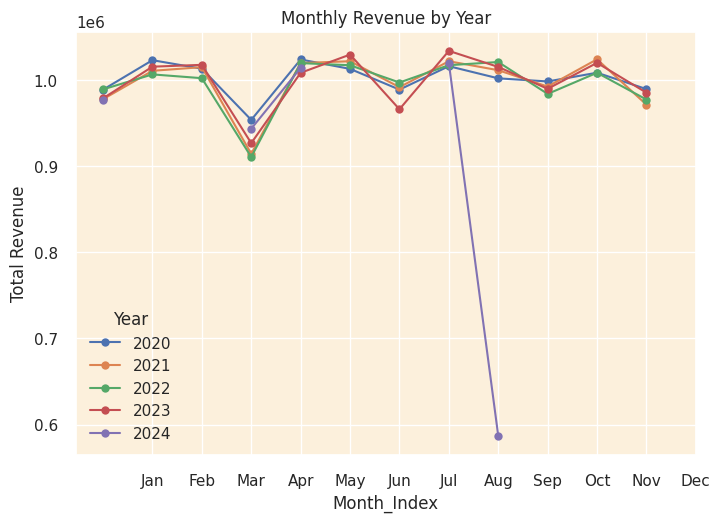

In [18]:
pivot.plot(kind='line', marker='o')
plt.title("Monthly Revenue by Year")
plt.ylabel("Total Revenue")
plt.xticks(ticks=range(1,13), labels=calendar.month_abbr[1:13])
plt.grid(True)
plt.show()


In [19]:
# Finding the number of unique products
unique_products = df['Product'].nunique()

# Printing the number of unique products
print(f"The number of unique products in the dataset is: {unique_products}")

The number of unique products in the dataset is: 571947


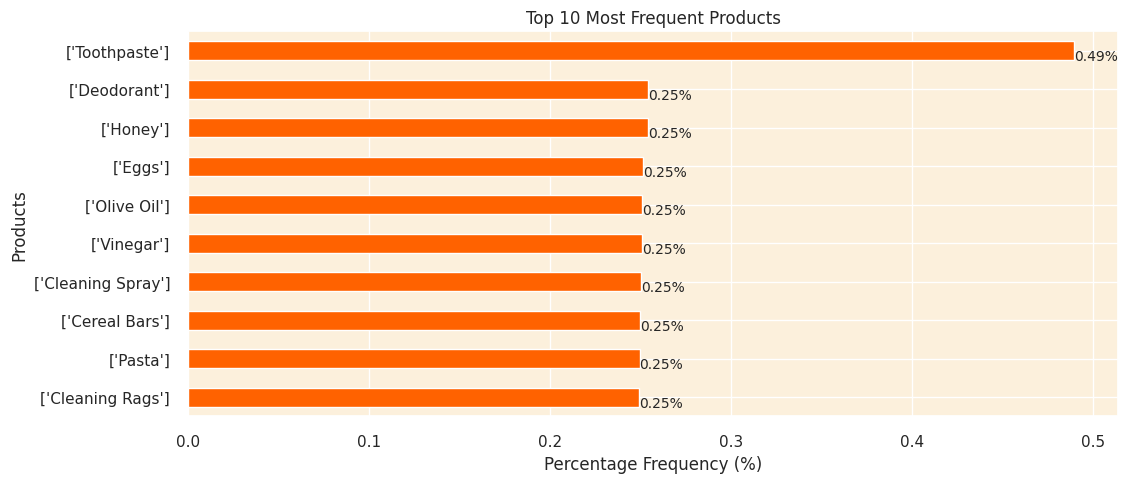

In [20]:
# Finding the top 10 most frequently Bought product
top_10_product = df['Product'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequently Bought product
plt.figure(figsize=(12, 5))
top_10_product.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_product):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Products')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Products')
plt.gca().invert_yaxis()
plt.show()

## Analyze sales



In [21]:
# Sales by payment method

sales_by_payment_method = df.groupby('Payment_Method')['Total_Cost'].sum().reset_index()
sales_by_payment_method = sales_by_payment_method.sort_values(by='Total_Cost', ascending=False)
print(sales_by_payment_method)

# Sales by city

sales_by_city = df.groupby('City')['Total_Cost'].sum().reset_index()

lowest_sales_cities = sales_by_city.sort_values(by='Total_Cost', ascending=True).head()
highest_sales_cities = sales_by_city.sort_values(by='Total_Cost', ascending=False).head()

print("Cities with the lowest sales:")
print(lowest_sales_cities)

print("\nCities with the highest sales:")
print(highest_sales_cities)

# Sales by Store Type

sales_by_store_type = df.groupby('Store_Type')['Total_Cost'].sum().reset_index()
sales_by_store_type = sales_by_store_type.sort_values(by='Total_Cost', ascending=False)
print("Total sales by store type:")
print(sales_by_store_type)

   Payment_Method   Total_Cost
0            Cash  13133235.30
1     Credit Card  13123764.94
3  Mobile Payment  13103003.92
2      Debit Card  13095216.24
Cities with the lowest sales:
            City  Total_Cost
0        Atlanta  5202731.84
5    Los Angeles  5232393.19
9        Seattle  5235365.43
6          Miami  5240498.44
8  San Francisco  5241099.86

Cities with the highest sales:
       City  Total_Cost
3    Dallas  5277111.53
1    Boston  5263307.96
2   Chicago  5263187.45
7  New York  5252469.92
4   Houston  5247054.78
Total sales by store type:
          Store_Type  Total_Cost
2           Pharmacy  8766679.01
4        Supermarket  8763455.21
5     Warehouse Club  8760029.03
0  Convenience Store  8731901.36
1   Department Store  8731555.57
3    Specialty Store  8701600.22


## Analyze sales customer category




In [22]:
sales_by_customer_category = df.groupby('Customer_Category')['Total_Cost'].sum().reset_index()
sales_by_customer_category = sales_by_customer_category.sort_values(by='Total_Cost', ascending=False)
print("Total sales by customer category:")
print(sales_by_customer_category)

Total sales by customer category:
  Customer_Category  Total_Cost
6          Teenager  6582893.18
0         Homemaker  6579605.97
4    Senior Citizen  6568220.19
3           Retiree  6558223.95
5           Student  6552706.16
2      Professional  6547388.77
7       Young Adult  6533845.14
1       Middle-Aged  6532337.04


## Analyze sales by season




In [23]:
seasonal_sales = df.groupby('Season')['Total_Cost'].sum().reset_index()
seasonal_sales = seasonal_sales.sort_values(by='Total_Cost', ascending=False)
print("Total sales by season:")
print(seasonal_sales)

Total sales by season:
   Season   Total_Cost
0    Fall  13136913.71
2  Summer  13116675.79
1  Spring  13113238.75
3  Winter  13088392.15


## Analyze sales by promotion type



In [24]:
promotion_sales = df.groupby('Promo_type')['Total_Cost'].sum().reset_index()
promotion_sales = promotion_sales.sort_values(by='Total_Cost', ascending=False)
print("Total sales by promotion type:")
print(promotion_sales)

Total sales by promotion type:
             Promo_type   Total_Cost
0              Discount  26248916.26
1  Promosi Non Discount  26206304.14


# Analyze sales by total items



In [25]:
# Calculate average cost per item
df['Average_Cost_Per_Item'] = df['Total_Cost'] / df['Total_Items']


Analyze which products are mainly sold during which season.

In [26]:
import ast

product_transaction_matrix = df[['Transaction_ID', 'Product']].copy()
product_transaction_matrix['Product'] = product_transaction_matrix['Product'].apply(ast.literal_eval)
product_transaction_matrix = product_transaction_matrix.explode('Product')
product_transaction_matrix['Product'] = product_transaction_matrix['Product'].str.strip()


seasonal_product_sales = pd.merge(product_transaction_matrix, df[['Transaction_ID', 'Season']], on='Transaction_ID')

seasonal_product_counts = seasonal_product_sales.groupby(['Season', 'Product']).size().reset_index(name='Product_Count')


top_n = 10
top_products_by_season = seasonal_product_counts.groupby('Season').apply(lambda x: x.nlargest(top_n, 'Product_Count')).reset_index(drop=True)
display(top_products_by_season)


,Season,Product,Product_Count
0,Fall,Toothpaste,18412
1,Fall,Ironing Board,9435
2,Fall,Peanut Butter,9353
3,Fall,Ice Cream,9331
4,Fall,Coffee,9330
5,Fall,Air Freshener,9323
6,Fall,Trash Cans,9288
7,Fall,Shampoo,9282
8,Fall,Tomatoes,9282
9,Fall,Pasta,9275


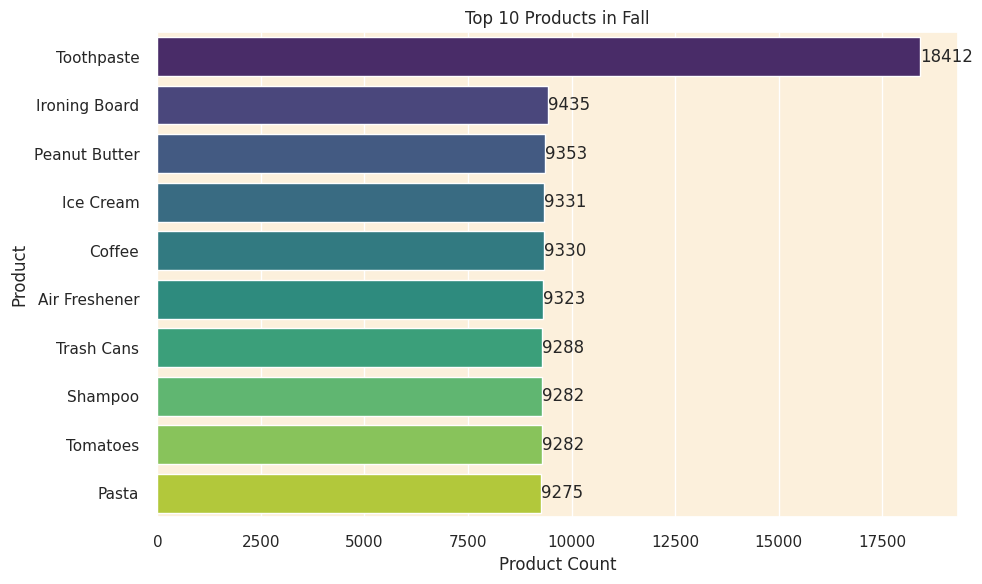

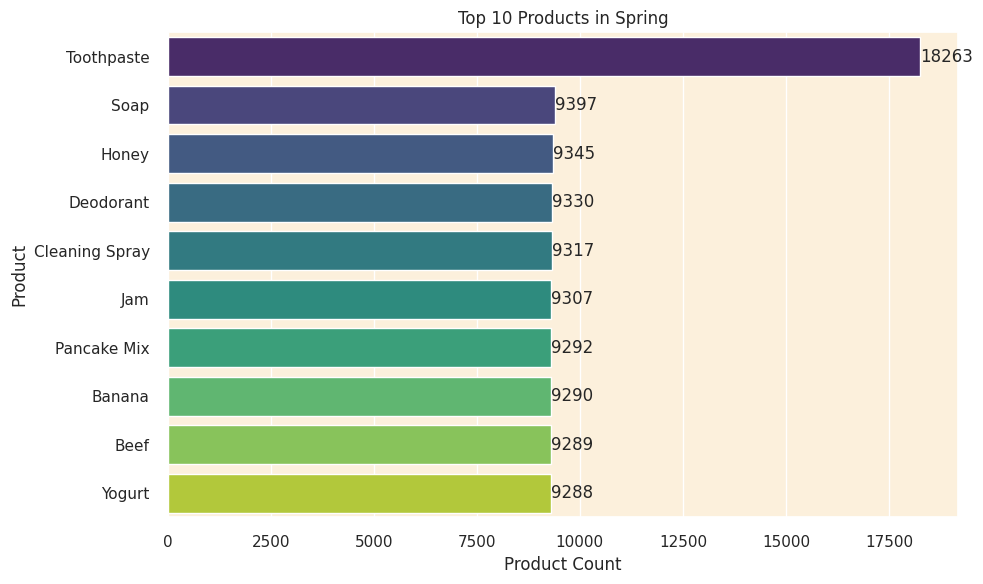

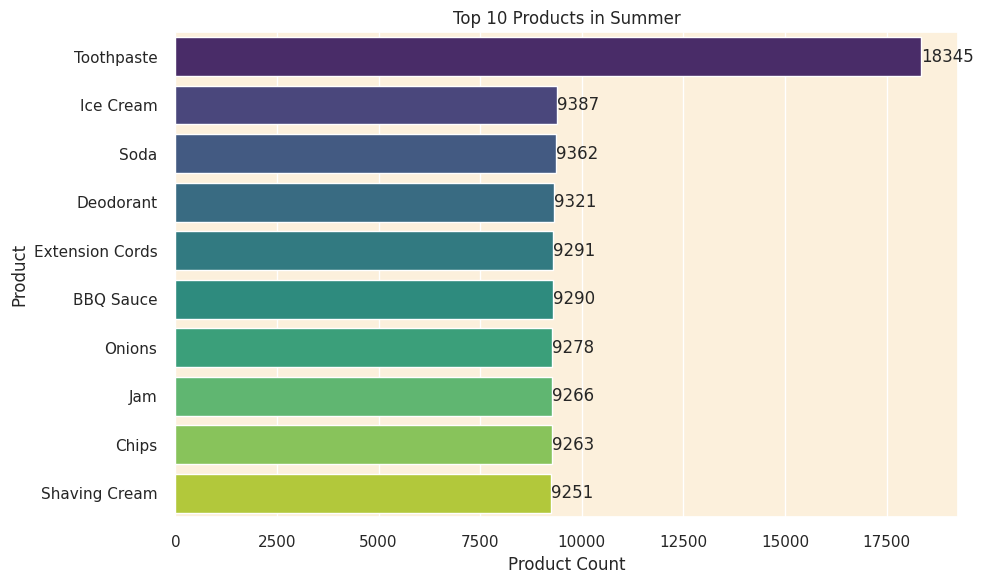

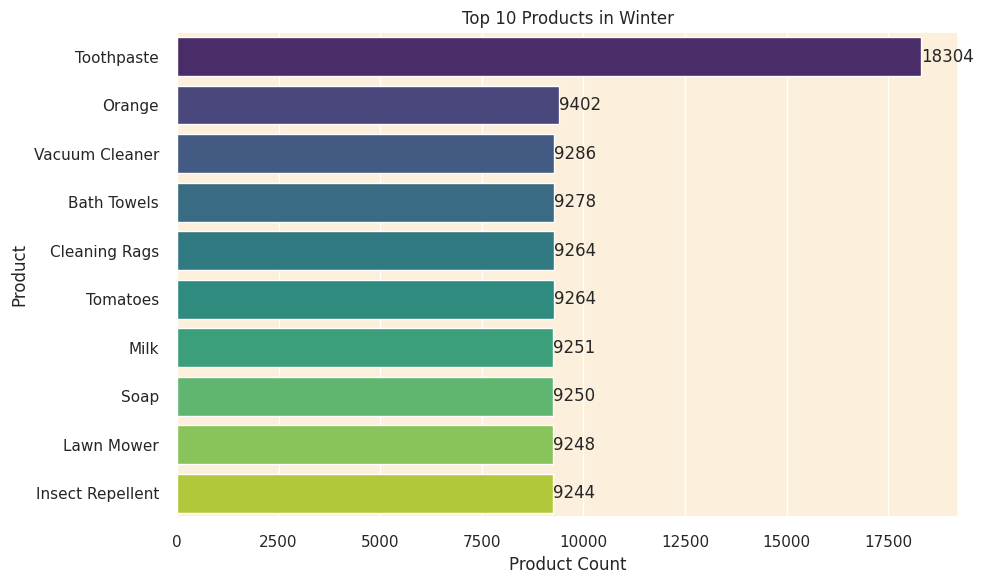

In [27]:
for season in top_products_by_season['Season'].unique():
    season_data = top_products_by_season[top_products_by_season['Season'] == season]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Product_Count', y='Product', data=season_data, palette='viridis')
    plt.title(f'Top {top_n} Products in {season}')
    plt.xlabel('Product Count')
    plt.ylabel('Product')
    for index, value in enumerate(season_data['Product_Count']):
        plt.text(value, index, str(value), va='center')
    plt.tight_layout()
    plt.show()

# Analyze store type performance trends

In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [29]:
payment_method_trends = df.groupby(['Year', 'Payment_Method'])['Transaction_ID'].nunique().reset_index()
display(payment_method_trends.head())

,Year,Payment_Method,Transaction_ID
0,2020,Cash,57149
1,2020,Credit Card,57277
2,2020,Debit Card,57453
3,2020,Mobile Payment,56828
4,2021,Cash,57088


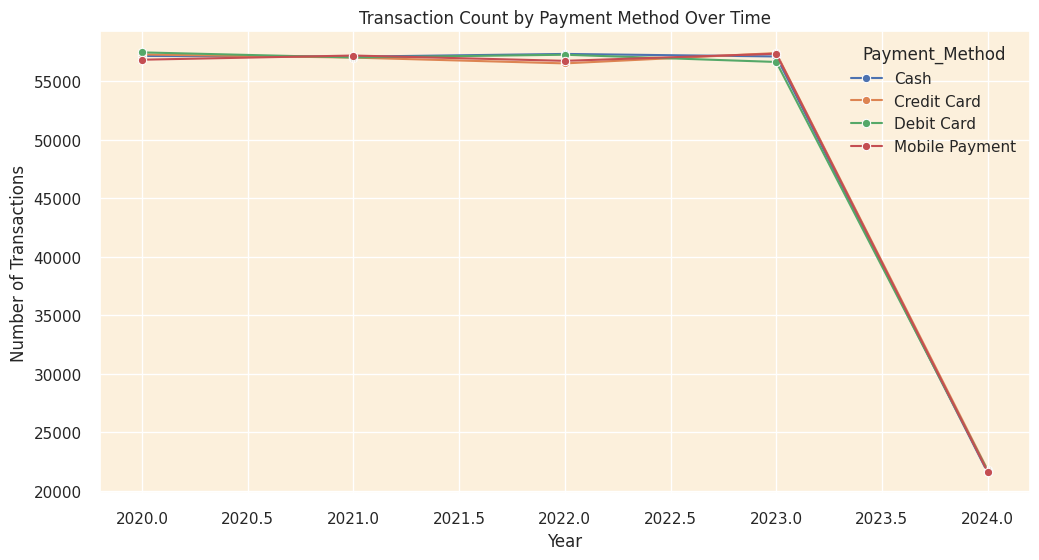

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=payment_method_trends, x='Year', y='Transaction_ID', hue='Payment_Method', marker='o')
plt.title("Transaction Count by Payment Method Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

#Analyze store type performance trends


In [31]:
store_type_sales_trends = df.groupby(['Year', 'Store_Type'])['Total_Cost'].sum().reset_index()
display(store_type_sales_trends.head())

,Year,Store_Type,Total_Cost
0,2020,Convenience Store,2003204.23
1,2020,Department Store,1977310.32
2,2020,Pharmacy,1992193.36
3,2020,Specialty Store,1993090.82
4,2020,Supermarket,2015496.77



Examine the sales figures for each store type across the years to identify patterns or changes.


In [32]:
store_type_sales_trends['Sales_Change'] = store_type_sales_trends.groupby('Store_Type')['Total_Cost'].pct_change() * 100
display(store_type_sales_trends)

,Year,Store_Type,Total_Cost,Sales_Change
0,2020,Convenience Store,2003204.23,NaN
1,2020,Department Store,1977310.32,NaN
2,2020,Pharmacy,1992193.36,NaN
3,2020,Specialty Store,1993090.82,NaN
4,2020,Supermarket,2015496.77,NaN
5,2020,Warehouse Club,2034255.05,NaN
6,2021,Convenience Store,1998643.84,-0.227655
7,2021,Department Store,2000814.86,1.188713
8,2021,Pharmacy,1990824.56,-0.068708
9,2021,Specialty Store,1968734.52,-1.222037


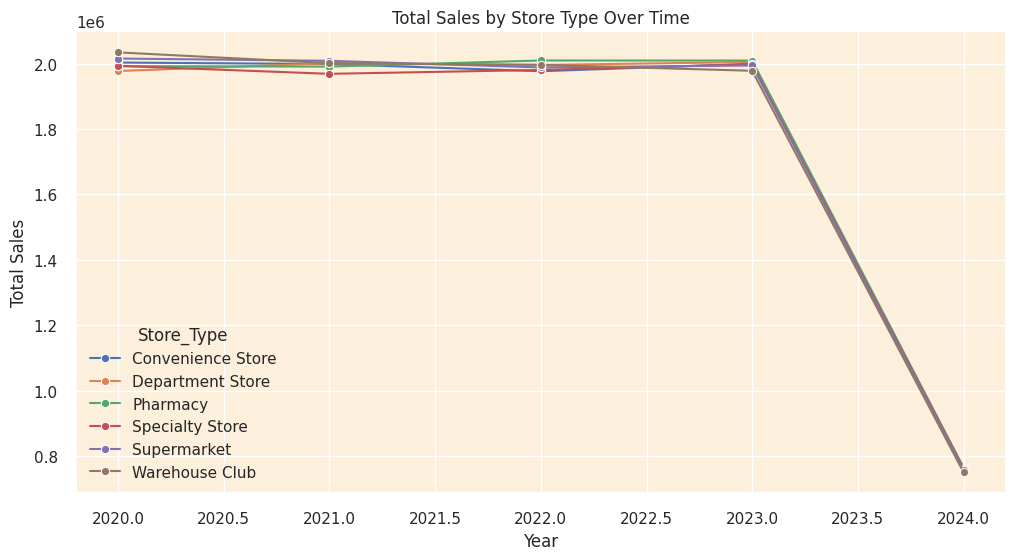

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=store_type_sales_trends, x='Year', y='Total_Cost', hue='Store_Type', marker='o')
plt.title("Total Sales by Store Type Over Time")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

#Analyze customer category trends by year



Examine the sales figures for each customer category across the years to identify patterns or changes.


In [34]:
customer_category_sales_trends['Sales_Change'] = customer_category_sales_trends.groupby('Customer_Category')['Total_Cost'].pct_change() * 100
display(customer_category_sales_trends)

NameError: name 'customer_category_sales_trends' is not defined

In [35]:
customer_category_sales_trends = df.groupby(['Year', 'Customer_Category'])['Total_Cost'].sum().reset_index()

customer_category_sales_trends['Sales_Change'] = customer_category_sales_trends.groupby('Customer_Category')['Total_Cost'].pct_change() * 100
display(customer_category_sales_trends)

,Year,Customer_Category,Total_Cost,Sales_Change
0,2020,Homemaker,1506365.30,NaN
1,2020,Middle-Aged,1507353.27,NaN
2,2020,Professional,1495536.83,NaN
3,2020,Retiree,1507006.72,NaN
4,2020,Senior Citizen,1502218.72,NaN
5,2020,Student,1492850.56,NaN
6,2020,Teenager,1499802.57,NaN
7,2020,Young Adult,1504416.58,NaN
8,2021,Homemaker,1500998.66,-0.356264
9,2021,Middle-Aged,1486042.54,-1.413785


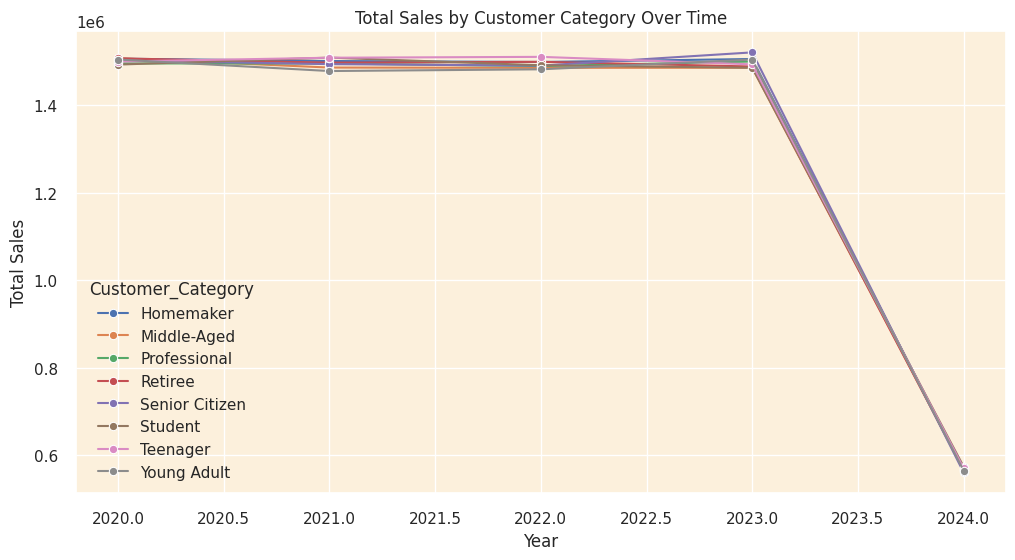

In [36]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=customer_category_sales_trends, x='Year', y='Total_Cost', hue='Customer_Category', marker='o')
plt.title("Total Sales by Customer Category Over Time")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

#Analyze promotion effectiveness trends


In [37]:
promotion_sales_trends = df.groupby(['Year', 'Promo_type'])['Total_Cost'].sum().reset_index()
display(promotion_sales_trends.head())

,Year,Promo_type,Total_Cost
0,2020,Discount,6024057.11
1,2020,Promosi Non Discount,5991493.44
2,2021,Discount,5972105.15
3,2021,Promosi Non Discount,5996805.77
4,2022,Discount,5972121.43


In [38]:
promotion_sales_trends['Sales_Change'] = promotion_sales_trends.groupby('Promo_type')['Total_Cost'].pct_change() * 100
display(promotion_sales_trends)

,Year,Promo_type,Total_Cost,Sales_Change
0,2020,Discount,6024057.11,NaN
1,2020,Promosi Non Discount,5991493.44,NaN
2,2021,Discount,5972105.15,-0.862408
3,2021,Promosi Non Discount,5996805.77,0.088665
4,2022,Discount,5972121.43,0.000273
5,2022,Promosi Non Discount,5974911.47,-0.365099
6,2023,Discount,6014847.91,0.715432
7,2023,Promosi Non Discount,5968680.27,-0.104289
8,2024,Discount,2265784.66,-62.330142
9,2024,Promosi Non Discount,2274413.19,-61.894203


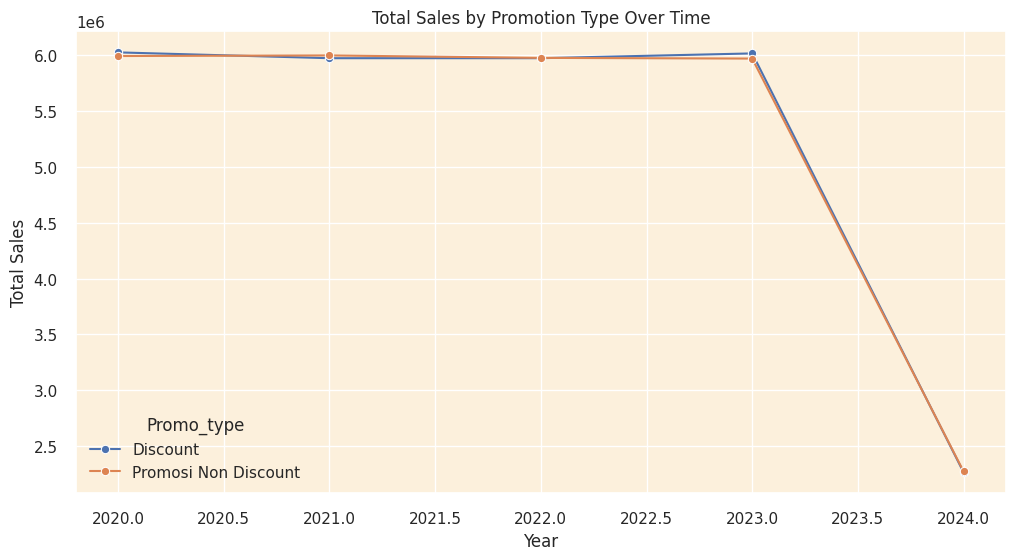

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=promotion_sales_trends, x='Year', y='Total_Cost', hue='Promo_type', marker='o')
plt.title("Total Sales by Promotion Type Over Time")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

## Combine relevant features




In [40]:
customer_data = df.groupby('Customer_Name').agg(
    total_transactions=('Transaction_ID', 'nunique'),
    total_items_purchased=('Total_Items', 'sum'),
    total_money_spent=('Total_Cost', 'sum')
).reset_index()

customer_features = customer_data[['total_transactions', 'total_items_purchased', 'total_money_spent']]
display(customer_data.head())

,Customer_Name,total_transactions,total_items_purchased,total_money_spent
0,Aaron Acevedo,4,13,279.85
1,Aaron Acosta,3,13,215.32
2,Aaron Adams,12,77,772.36
3,Aaron Adkins,3,11,118.52
4,Aaron Aguilar,5,32,236.76


## Perform customer segmentation




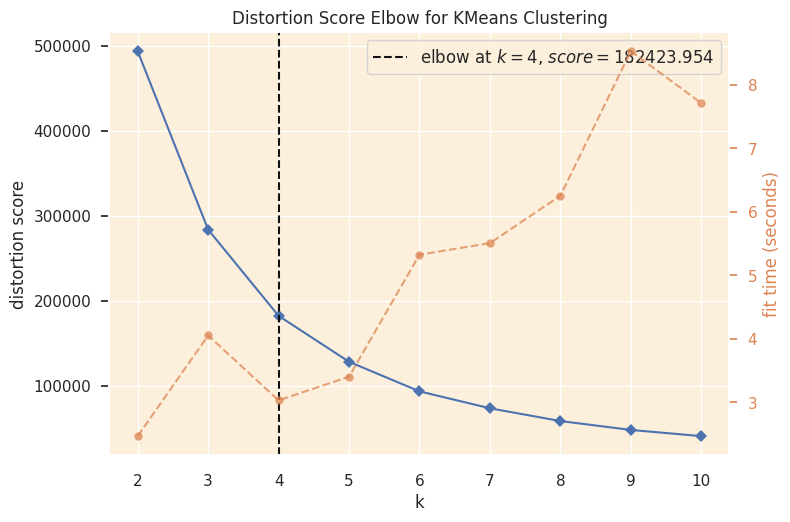

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
scaler = StandardScaler()
scaled_customer_features = scaler.fit_transform(customer_features)

# Determine the optimal number of clusters using the Elbow method
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=(2, 11))
elbow_visualizer.fit(scaled_customer_features)
elbow_visualizer.show()

## Analyze customer behavior

Study customer purchasing patterns, frequency, and value.


In [42]:
optimal_clusters = elbow_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data['cluster'] = kmeans.fit_predict(scaled_customer_features)

cluster_characteristics = customer_data.groupby('cluster')[customer_features.columns].mean()
print("Cluster Characteristics (Average Values):")
display(cluster_characteristics)

Cluster Characteristics (Average Values):


,total_transactions,total_items_purchased,total_money_spent
cluster,,,
0,1.825333,9.970299,95.042797
1,10.953904,60.880452,580.974513
2,125.054381,687.120846,6579.220000
3,39.102014,215.064652,2062.586875


In [43]:
# Calculate average items per transaction
customer_data['avg_items_per_transaction'] = customer_data['total_items_purchased'] / customer_data['total_transactions']

# Calculate average cost per transaction
customer_data['avg_cost_per_transaction'] = customer_data['total_money_spent'] / customer_data['total_transactions']

# Calculate the date range for frequency calculation
date_range_days = (df['Date'].max() - df['Date'].min()).days
date_range_years = date_range_days / 365.25

# Calculate average frequency of transactions (transactions per year)
customer_data['transaction_frequency_per_year'] = customer_data['total_transactions'] / date_range_years

display(customer_data.head())

,Customer_Name,total_transactions,total_items_purchased,total_money_spent,cluster,avg_items_per_transaction,avg_cost_per_transaction,transaction_frequency_per_year
0,Aaron Acevedo,4,13,279.85,0,3.250000,69.962500,0.913696
1,Aaron Acosta,3,13,215.32,0,4.333333,71.773333,0.685272
2,Aaron Adams,12,77,772.36,1,6.416667,64.363333,2.741088
3,Aaron Adkins,3,11,118.52,0,3.666667,39.506667,0.685272
4,Aaron Aguilar,5,32,236.76,0,6.400000,47.352000,1.142120


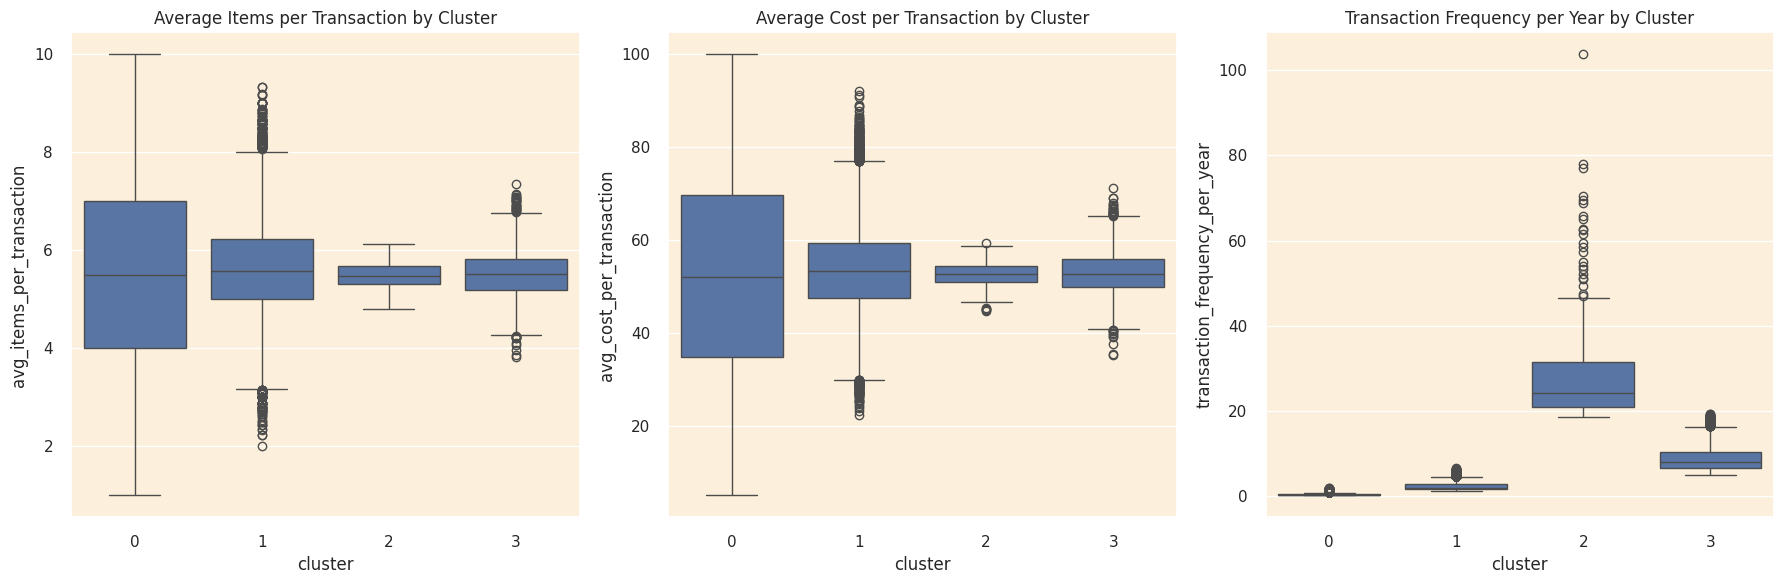

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x='cluster', y='avg_items_per_transaction', data=customer_data, ax=axes[0])
axes[0].set_title('Average Items per Transaction by Cluster')
sns.boxplot(x='cluster', y='avg_cost_per_transaction', data=customer_data, ax=axes[1])
axes[1].set_title('Average Cost per Transaction by Cluster')
sns.boxplot(x='cluster', y='transaction_frequency_per_year', data=customer_data, ax=axes[2])
axes[2].set_title('Transaction Frequency per Year by Cluster')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The most popular payment methods by total sales are Cash, Credit Card, Mobile Payment, and Debit Card, in descending order of sales volume.
*   Cities with the highest sales include Dallas, Boston, Chicago, New York, and Houston, while those with the lowest sales are Atlanta, Los Angeles, Seattle, Miami, and San Francisco.
*   Pharmacies, Supermarkets, and Warehouse Clubs are the top-performing store types based on total sales.
*   Customer categories contributing most to sales are Teenagers, Homemakers, and Senior Citizens.
*   Sales by season show minor fluctuations, with Fall having the highest sales and Winter the lowest; however, the differences are not substantial, indicating no drastically strong seasonal trend based on total revenue alone.
*   'Discount' promotions generated slightly higher total sales than 'Promosi Non Discount'.
*   There is a very weak linear relationship between the total number of items purchased and the total cost, suggesting that other factors significantly influence the total cost per transaction.
*   Customer segmentation using K-Means clustering identified distinct groups based on transaction volume, items purchased, and money spent. Analysis of average items per transaction, average cost per transaction, and transaction frequency per year by cluster highlighted differences in purchasing patterns across segments.
*   Outlier detection identified a significant number of customers (45,344 in the provided output) with unusual purchasing behavior that may warrant further investigation.
*   A linear regression model using lagged weekly sales for forecasting resulted in a Mean Squared Error (MSE) of 41483714.45 and a Root Mean Squared Error (RMSE) of 6440.79, suggesting that while the model captures some trend, there is a notable level of prediction error.


